# Import libraries

In [ ]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL
from PIL import Image
from google.colab.patches import cv2_imshow
from dataclasses import dataclass
from pathlib import Path
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Section 1**: Find corners

In [ ]:
def find_centroids(dst, gray):
    ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100,
                0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids[1:]),(5,5),
              (-1,-1),criteria)
    return corners

Change thresholds in cornerHarris

5 , 5 is the size of detecting neighborhood block size.
Must be odd and not larger than 31

0.1 is k : Harris dector free parameter

In [ ]:
def corners_num(map):
    dst = cv2.cornerHarris(map,5,5,0.1)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    #print (len(dst))
    plt.imshow(dst, cmap="gray")
    # Get coordinates
    corners = find_centroids(dst, map)
    #print(corners)
    # count corners
    int_corners = np.asarray(corners, dtype = int)
    #print ("Num of corners in map: ",len(int_corners))
    corner_num = len(int_corners)
    return corner_num

Display: Show img(map) with corners marked

In [ ]:
#plt.imshow(map, cmap="gray")
#plt.scatter(int_corners[:, 0], int_corners[:, 1])

# **Section 2**: Find enclosing area

In [ ]:
def enclosing_area(map):
    # apply thresholding on the gray image to create a binary image
    _, mapbin = cv2.threshold(map,127,255,cv2.THRESH_BINARY_INV)
    #plt.imshow(mapbin, cmap="gray")
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mapbin, connectivity=8)

    #area_count = num_labels -1 #exclude background
    #print(centroids)

    # apply thresholding on the gray image to create a binary image
    ret,thresh = cv2.threshold(map,127,255,0)
    #print ("threshold: ", thresh)
    #plt.imshow(thresh, cmap="gray")

    # find the contours
    contours, _ = cv2.findContours(mapbin,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # counting number of contours
    enclosing_area_num=len(contours)
    #print ("Number of contours: ", enclosing_area_num)

    return enclosing_area_num


Display

# **Section 3 & 4**: Certainty of cell and explored area

for i in range(100):
  print(filtered_intensity[i+500])

In [ ]:
def accuracy_and_explored(map):
    # Convert the image to a NumPy array to access intensity values
    intensity = np.array(map)

    # Print the intensity values
    #print(intensity)
    wid = map.shape[1]# fetching the dimensions
    hgt = map.shape[0]
    #print(size)
    # exclude grey
    filtered_intensity = intensity[intensity != 205]

    #print(filtered_intensity)

    newsize = len(filtered_intensity)
    #print(newsize)
    # calculate score for how certain robot is with the map
    # the closer the number is to 0 or 255, the higher the score

    #initial array for score
    score = np.zeros(newsize)

    #for lower than 12
    for i in range(newsize):
      if (filtered_intensity[i]<205):
        score[i] = 100 * (1-(filtered_intensity[i]/205))
      else:
        score[i] = 100 * (1-(255-filtered_intensity[i])/50)

    # find average in score
    sum = np.sum(score)
    accuracy = sum/7500
    #print(accuracy)
    return accuracy, newsize

# **time**

In [ ]:
# Extract timestamps from filenames using regex
def extract_timestamp(filename):
    match = re.search(r'_(\d+)_(?:tb3_0|tb3_1|main)\.png$', filename)
    if match:
        return int(match.group(1))
    else:
        return 0


# **save csv**

In [ ]:
def save_csv(mapinfos, attempt):
  # Save csv
  # Define the CSV file name
  csv_file = "/content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi" + attempt + ".csv"

  # Extract field names from mapinfo dataclass
  keys = mapinfos[0].__dict__.keys()

  # Open the file and write data
  with open(csv_file, mode="w", newline="") as file:
      writer = csv.DictWriter(file, fieldnames=keys)

      # Write the header
      writer.writeheader()

      # Write the data from mapinfos
      for mapinfo_obj in mapinfos:
          writer.writerow(mapinfo_obj.__dict__)

  print(f"Map info successfully saved to {csv_file}")


# **Main**

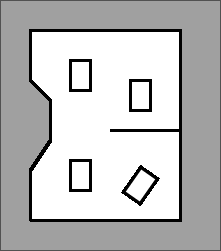

221 251
22 12 62.315832795075075 55471


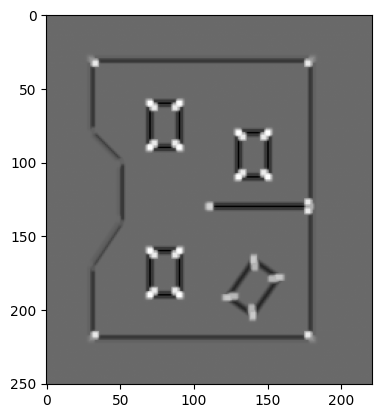

In [ ]:
map=cv2.imread('/content/drive/MyDrive/FYP_multirobotSLAM/maps/Untitled Diagram.drawio(2).png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(map)
wid = map.shape[1]# fetching the dimensions
hgt = map.shape[0]
print(wid, hgt)
#score1 = corners_num(map)
score2 = enclosing_area(map)
score3, score4 = accuracy_and_explored(map)
print(score1, score2, score3, score4)

Number of contours:  12


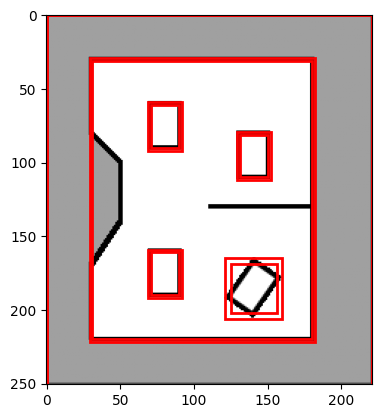

In [ ]:
# apply thresholding on the gray image to create a binary image
_, mapbin = cv2.threshold(map,127,255,cv2.THRESH_BINARY_INV)
#plt.imshow(mapbin, cmap="gray")
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mapbin, connectivity=8)

#area_count = num_labels -1 #exclude background
#print(centroids)

# apply thresholding on the gray image to create a binary image
ret,thresh = cv2.threshold(map,127,255,0)
#print ("threshold: ", thresh)
#plt.imshow(thresh, cmap="gray")

# find the contours
contours, _ = cv2.findContours(mapbin,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# counting number of contours
enclosing_area_num=len(contours)
print ("Number of contours: ", enclosing_area_num)

for i in range(enclosing_area_num):
  cnt = contours[i]

  # compute the bounding rectangle of the contour
  x,y,w,h = cv2.boundingRect(cnt)

  # draw contour
  #map = cv2.drawContours(map,[cnt],0,(0,255,255),2)

  # draw the bounding rectangle
  #map = cv2.rectangle(map,(x,y),(x+w,y+h),(0,255,0),2)

  # display the image
  plt.imshow(map, cmap="gray")

  #add rectangle
  plt.gca().add_patch(Rectangle((x,y),w,h,
                      edgecolor='red',
                      facecolor='none',
                      lw=2))

map=cv2.imread('/content/drive/MyDrive/FYP_multirobotSLAM/maps/Untitled Diagram.drawio(2).png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(map)
wid = map.shape[1]# fetching the dimensions
hgt = map.shape[0]
print(wid, hgt)
score1 = corners_num(map)
score2 = enclosing_area(map)
score3, score4 = accuracy_and_explored(map)
print(score1, score2, score3, score4)

In [ ]:
for attempts in range(19):
  # get the path/directory
  folder_dir = '/content/drive/MyDrive/FYP_multirobotSLAM/maps/Experiment/Multi/'
  attempt=str(attempts+1)
  folder_dir = folder_dir + attempt

  # iterate over files in
  # that directory
  images = Path(folder_dir).glob('*.png')
  # init list
  mapnames=list()

  for image in images:
    mapnames.append(str(image))
  mapnames.sort()

  @dataclass
  class mapinfo:
      id: int
      filename: str
      #maptype: str
      width: int
      height: int
      timestep: int
      score1: int
      score2: int
      score3: int
      score4: int #explored pixel
      total_score: int

  # Create objects
  mapinfos = [mapinfo(0, 'name', 0, 0, 0, 0, 0, 0, 0, 0) for i in range(len(mapnames))]

  # Get the timestamp of the first image
  first_timestamp = extract_timestamp(mapnames[0])
  print(first_timestamp)
  print("attempt"+attempt)
  # call functions and save scores
  for i in range(len(mapnames)):
    map = cv2.imread(mapnames[i], cv2.IMREAD_GRAYSCALE)
    #cv2_imshow(map)
    wid = map.shape[1]# fetching the dimensions
    hgt = map.shape[0]
    mapinfos[i].id = i
    name=mapnames[i]
    mapinfos[i].filename = name
    mapinfos[i].maptype = name[-9:-4]
    mapinfos[i].width = wid
    mapinfos[i].height = hgt
    mapinfos[i].timestep = extract_timestamp(mapnames[i]) - first_timestamp
    #mapinfos[i].score1 = corners_num(map)
    #mapinfos[i].score2 = enclosing_area(map)
    mapinfos[i].score3, _ = accuracy_and_explored(map)
    #mapinfos[i].total_score = mapinfos[i].score1 + mapinfos[i].score2 + mapinfos[i].score3 + mapinfos[i].score4
    #print(mapinfos[i].id, mapinfos[i].score1, mapinfos[i].score2, mapinfos[i].score3, mapinfos[i].score4, mapinfos[i].total_score)

  save_csv(mapinfos, attempt)

1742300426
attempt1
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi1.csv
1742300919
attempt2
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi2.csv
1742301525
attempt3
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi3.csv
1742302032
attempt4
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi4.csv
1742302640
attempt5
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi5.csv
1742309434
attempt6
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi6.csv
1742310138
attempt7
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/score_csv_new/map_scores_multi7.csv
1742310679
attempt8
Map info successfully saved to /content/drive/MyDrive/FYP_multirobotSLAM/scor

In [ ]:
# Plot
# corners
#for i in range(len(mapnames)):
  #plt.scatter(mapinfos[i].id,mapinfos[i].score1, label = "Corners")
  #plt.scatter(mapinfos[i].id,mapinfos[i].score2, label = "Enclosing Area")
  #plt.scatter(mapinfos[i].id,mapinfos[i].score3, label = "Accuracy")
  #plt.scatter(mapinfos[i].id,mapinfos[i].score4, label = "Explored Area")
  #plt.scatter(mapinfos[i].id,mapinfos[i].total_score, label = "Total Score")